In [7]:
# Import Necessary Libraries
import numpy as np
import matplotlib.pyplot as plt

import adaptive_time.tiles3 as tc

from adaptive_time.utils import argmax
from adaptive_time.mountain_car_learn import mountaincar_env
from adaptive_time.mountain_car_learn import sparse_mountain_car
from adaptive_time.mountain_car_learn.agent import BaseAgent
from adaptive_time.mountain_car_learn.rl_glue import RLGlue

import time

from tqdm.notebook import tqdm

# Train on Mountain Car

In [8]:
# Tile Coding Function [Graded]
class MountainCarTileCoder:
    def __init__(self, iht_size=4096, num_tilings=8, num_tiles=8):
        """
        Initializes the MountainCar Tile Coder
        Initializers:
        iht_size -- int, the size of the index hash table, typically a power of 2
        num_tilings -- int, the number of tilings
        num_tiles -- int, the number of tiles. Here both the width and height of the
                     tile coder are the same
        Class Variables:
        self.iht -- tc.IHT, the index hash table that the tile coder will use
        self.num_tilings -- int, the number of tilings the tile coder will use
        self.num_tiles -- int, the number of tiles the tile coder will use
        """
        self.iht = tc.IHT(iht_size)
        self.num_tilings = num_tilings
        self.num_tiles = num_tiles
    
    def get_tiles(self, position, velocity):
        """
        Takes in a position and velocity from the mountaincar environment
        and returns a numpy array of active tiles.
        
        Arguments:
        position -- float, the position of the agent between -1.2 and 0.5
        velocity -- float, the velocity of the agent between -0.07 and 0.07
        returns:
        tiles - np.array, active tiles
        """
        # Set the max and min of position and velocity to scale the input
        # POSITION_MIN
        # POSITION_MAX
        # VELOCITY_MIN
        # VELOCITY_MAX
        ### START CODE HERE ###
        POSITION_MIN = -1.2
        POSITION_MAX = 0.5
        VELOCITY_MIN = -0.07
        VELOCITY_MAX = 0.07
        ### END CODE HERE ###
        
        # Use the ranges above and self.num_tiles to set position_scale and velocity_scale
        # position_scale = number of tiles / position range
        # velocity_scale = number of tiles / velocity range
        
        # Scale position and velocity by multiplying the inputs of each by their scale
        
        ### START CODE HERE ###
        position_scale = self.num_tiles / (POSITION_MAX - POSITION_MIN)
        velocity_scale = self.num_tiles / (VELOCITY_MAX - VELOCITY_MIN)
        ### END CODE HERE ###
        
        # get the tiles using tc.tiles, with self.iht, self.num_tilings and [scaled position, scaled velocity]
        # nothing to implment here
        tiles = tc.tiles(self.iht, self.num_tilings, [position * position_scale, 
                                                      velocity * velocity_scale])
        
        return np.array(tiles)

In [9]:
# [DO NOT CHANGE]
tests = [[-1.0, 0.01], [0.1, -0.01], [0.2, -0.05], [-1.0, 0.011], [0.2, -0.05]]

mctc = MountainCarTileCoder(iht_size=1024, num_tilings=8, num_tiles=8)

t = []
for test in tests:
    position, velocity = test
    tiles = mctc.get_tiles(position=position, velocity=velocity)
    t.append(tiles)

print("Your results:")
for tiles in t:
    print(tiles)

print()
print("Expected results:")
expected = """[0 1 2 3 4 5 6 7]
[ 8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23]
[ 0 24  2  3  4  5  6  7]
[16 17 18 19 20 21 22 23]
"""
print(expected)

np.random.seed(1)
mctc_test = MountainCarTileCoder(iht_size=1024, num_tilings=8, num_tiles=8)
test = [mctc_test.get_tiles(np.random.uniform(-1.2, 0.5), np.random.uniform(-0.07, 0.07)) for _ in range(10)]
np.save("tiles_test", test)

Your results:
[0 1 2 3 4 5 6 7]
[ 8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23]
[ 0 24  2  3  4  5  6  7]
[16 17 18 19 20 21 22 23]

Expected results:
[0 1 2 3 4 5 6 7]
[ 8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23]
[ 0 24  2  3  4  5  6  7]
[16 17 18 19 20 21 22 23]



In [10]:
# LSVI-PHE
class SarsaAgent(BaseAgent):
    """
    Initialization of Sarsa Agent. All values are set to None so they can
    be initialized in the agent_init method.
    """
    def __init__(self):
        self.last_action = None
        self.last_state = None
        self.epsilon = None
        self.gamma = None
        self.iht_size = None
        self.w = None
        self.alpha = None
        self.num_tilings = None
        self.num_tiles = None
        self.mctc = None
        self.initial_weights = None
        self.num_actions = None
        self.previous_tiles = None

    def agent_init(self, agent_info={}):
        """Setup for the agent called when the experiment first starts."""
        self.num_tilings = agent_info.get("num_tilings", 8)
        self.num_tiles = agent_info.get("num_tiles", 8)
        self.iht_size = agent_info.get("iht_size", 4096)
        self.epsilon = agent_info.get("epsilon", 0.0)
        self.gamma = agent_info.get("gamma", 1.0)
        self.alpha = agent_info.get("alpha", 0.5) / self.num_tilings
        self.initial_weights = agent_info.get("initial_weights", 0.0)
        self.num_actions = agent_info.get("num_actions", 3)
        
        
        
        # We initialize self.w to three times the iht_size. Recall this is because
        # we need to have one set of weights for each action.
        self.w = np.ones((self.num_actions, self.iht_size)) * self.initial_weights
        
        #Optimisitc Sampling BEGIN
        #These are needed for optimistic sampling 
        
        #The array that stores the randomized parameter
        self.rw = np.ones((self.num_actions, self.iht_size)) * self.initial_weights
        
        #This acts in place of the covariance matrix. It keeps a count of how many times a tiling was visited 
        #per action
        self.count = np.ones((self.num_actions, self.iht_size))
        
        #The number of samples used for optimistic sampling
        self.M = 2
        
        #Optimistic Sampling END
        
        # We initialize self.mctc to the mountaincar verions of the 
        # tile coder that we created
        self.tc = MountainCarTileCoder(iht_size=self.iht_size, 
                                         num_tilings=self.num_tilings, 
                                         num_tiles=self.num_tiles)

    def select_action(self, tiles):
        """
        Selects an action using epsilon greedy
        Args:
        tiles - np.array, an array of active tiles
        Returns:
        (chosen_action, action_value) - (int, float), tuple of the chosen action
                                        and it's value
        """
        action_values = []
        chosen_action = None
        
        # First loop through the weights of each action and populate action_values
        # with the action value for each action and tiles instance
        
        # Use np.random.random to decide if an exploritory action should be taken
        # and set chosen_action to a random action if it is
        # Otherwise choose the greedy action using the given argmax 
        # function and the action values (don't use numpy's armax)
        
        ### START CODE HERE ###
        action_values = np.zeros(self.num_actions)
        for action in range(self.num_actions):
            action_values[action] = np.sum(self.w[action][tiles])
        c = np.random.uniform()
        if c < self.epsilon:
            chosen_action = argmax(action_values)
        else:
            chosen_action = argmax(action_values)
        ### END CODE HERE ###
        
        return chosen_action, action_values[chosen_action]
    
    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state observation from the
                environment's evn_start function.
        Returns:
            The first action the agent takes.
        """
        position, velocity = state
        
        # Use self.tc to set active_tiles using position and velocity
        # set current_action to the epsilon greedy chosen action using
        # the select_action function above with the active tiles
        
        ### START CODE HERE ###
        active_tiles = self.tc.get_tiles(position, velocity)
        current_action, action_value = self.select_action(active_tiles)
        ### END CODE HERE ###
        
        self.last_action = current_action
        self.previous_tiles = np.copy(active_tiles)
        return self.last_action

    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (Numpy array): the state observation from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """
        # choose the action here
        position, velocity = state
        
        # Use self.tc to set active_tiles using position and velocity
        # set current_action and action_value to the epsilon greedy chosen action using
        # the select_action function above with the active tiles
        
        # Update self.w at self.previous_tiles and self.previous action
        # using the reward, action_value, self.gamma, self.w,
        # self.alpha, and the Sarsa update from the textbook
        
        ### START CODE HERE ###
        active_tiles = self.tc.get_tiles(position, velocity)
        current_action, action_value = self.select_action(active_tiles)
        last_action_value = np.sum(self.rw[self.last_action][self.previous_tiles])
        self.w[self.last_action][self.previous_tiles] += self.alpha * (reward + self.gamma * action_value - last_action_value) * 1

        #OPTIMSITIC SAMPLING BEGIN
        
        #This counts the number of times each tile as been activated per action
        #This actions in place of a covariance matrix for faster computation
        self.count[self.last_action][self.previous_tiles] += 1
                    
        
        #The optimistic sampling step
        
        #The array that stores the samples
        self.rmw = np.zeros((self.M,self.num_actions,self.iht_size))
        
        for m in range(self.M):
            for i in range(self.num_actions):
                #The randomization step, the variance shrinks as we visit more tiles/actions
                self.rmw[m,i,:] = np.random.normal(self.w[i,:],1.0/self.count[i,:])
        
        #Here is where we get the optmisitic sample. We take the max over samples per tile.
        for i in range(self.num_actions):
            self.rw[i,:] = np.amax(self.rmw[:,i,:],axis=0)
        #OPTIMSITIC SAMPLING END
        
        
        self.last_action = current_action
        self.previous_tiles = np.copy(active_tiles)
        return self.last_action

    def agent_end(self, reward):
        """Run when the agent terminates. Same as above except action_value = 0.0
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        # Update self.w at self.previous_tiles and self.previous action
        # using the reward, self.gamma, self.w,
        # self.alpha, and the Sarsa update from the textbook
        # Hint - there is no action_value used here because this is the end
        # of the episode.
        
        ### START CODE HERE ###
        last_action_value = np.sum(self.rw[self.last_action][self.previous_tiles])
        
        
        self.w[self.last_action][self.previous_tiles] += self.alpha * (reward - last_action_value) * 1
        
        
        #OPTIMISTIC SAMPLING BEGIN
        self.count[self.last_action][self.previous_tiles] += 1
        self.rmw = np.zeros((self.M,self.num_actions,self.iht_size))
        for m in range(self.M):
            for i in range(self.num_actions):
                self.rmw[m,i,:] = np.random.normal(self.w[i,:],1.0/self.count[i,:])
        
        for i in range(self.num_actions):
            self.rw[i,:] = np.amax(self.rmw[:,i,:],axis=0)
        
        #OPTIMISITIC SAMPLING END
        ### END CODE HERE ###
        
    def agent_cleanup(self):
        """Cleanup done after the agent ends."""
        pass

    def agent_message(self, message):
        """A function used to pass information from the agent to the experiment.
        Args:
            message: The message passed to the agent.
        Returns:
            The response (or answer) to the message.
        """
        pass

In [11]:
#Here is where we run LSVI-PHE on Sparse Mountain Car
#Everything is set as choosen from the RL I Coursera Course. 
#I only added M, sigma.

num_runs = 10
num_episodes = 50
env_info = {"num_tiles": 8, "num_tilings": 8}
agent_info = {}
all_steps = []

agent = SarsaAgent
env = sparse_mountain_car.Environment
start = time.time()

for run in tqdm(range(num_runs)):
    if run % 5 == 0:
        print("RUN: {}".format(run))

    rl_glue = RLGlue(env, agent)
    rl_glue.rl_init(agent_info, env_info)
    steps_per_episode = []

    for episode in range(num_episodes):
        rl_glue.rl_episode(15000)
        steps_per_episode.append(rl_glue.num_steps)
        #print(rl_glue.num_steps)        

    all_steps.append(np.array(steps_per_episode))

print("Run time: {}".format(time.time() - start))


  0%|          | 0/10 [00:00<?, ?it/s]

RUN: 0
RUN: 5
Run time: 47.82181692123413


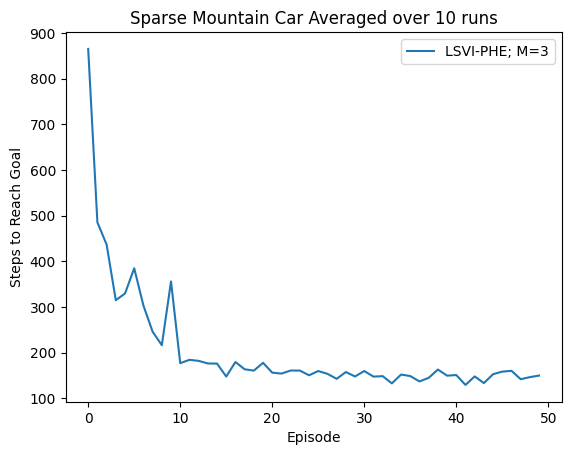

In [12]:
#PLOT RESULTS
plt.plot(np.mean(np.array(all_steps), axis=0),label='LSVI-PHE; M=3')
plt.xlabel("Episode")
plt.ylabel("Steps to Reach Goal")
plt.title("Sparse Mountain Car Averaged over " + str(num_runs) + " runs")
plt.legend()
# plt.savefig("sparse_mountain_car.pdf")
# np.save("sarsa_test", np.array(all_steps))

# Generate Good Trajectories

In [72]:
from importlib import reload

import gymnasium as gym
from adaptive_time import value_est
from adaptive_time import utils
from adaptive_time.environments import gym_mountain_car

import os

import matplotlib.pyplot as plt
import pickle
import numpy as np

from pprint import pprint

gym_mountain_car = reload(gym_mountain_car)
gym = reload(gym)

In [68]:
BASE_DIR = "classic_control_data"
data_descr = f"mountain_car"
traj_data_file = f"{data_descr}.pkl"


In [69]:

def generate_trajectory(
        gym_env, rl_glue_agent, max_steps=None):
    trajectory = []
    terminated = False
    steps = 0

    observation, _ = gym_env.reset()
    action = rl_glue_agent.agent_start(observation)

    while not terminated:
        steps += 1
        observation_, reward, terminated, truncated, info = gym_env.step(action)
        trajectory.append([observation, action, reward, observation_])
        observation = observation_
        action = rl_glue_agent.agent_start(observation)

        if max_steps is not None and steps > max_steps:
            return trajectory, True
            #print('Max steps reached!', steps)

    return trajectory, False


In [93]:
STEPS_MAX = 20000
dt = 0.01
seed = 13
NUM_TRAJS = 100

In [95]:

utils.set_directory_in_project()
traj_data_path = os.path.join(BASE_DIR, traj_data_file)


# env = gym.make('MountainCar-v0')
env = gym.make('MountainCar-OURS-v0', dt=dt)

value_est.reset_randomness(seed, env)

reward_sequences = []
total_rewards = []
traj_lengths = []

for _ in tqdm(range(NUM_TRAJS)):
    trajectory, early_term = generate_trajectory(
            env, rl_glue.agent, max_steps=STEPS_MAX)

    traj_lengths.append(len(trajectory))
    rewards = [r for _, _, r, _ in trajectory]

    reward_sequences.append(rewards)
    total_rewards.append(sum(rewards))


all_traj_data = (
    total_rewards, reward_sequences, traj_lengths,
    None
)

with open(traj_data_path, "wb") as f:
    pickle.dump(all_traj_data, f)
print("Saved data to", traj_data_path)

print("total_rewards for each traj:", total_rewards)
num_trajs = len(total_rewards)

print("typical trajectory length:", np.mean(traj_lengths))



Changed working directory to /Users/szepi1991/Code/adaptive_time


  0%|          | 0/100 [00:00<?, ?it/s]

Saved data to classic_control_data/mountain_car.pkl
total_rewards for each traj: [-111.21000000001999, -109.62000000001917, -109.74000000001924, -111.69000000002023, -120.98000000002499, -111.91000000002035, -117.75000000002333, -120.26000000002462, -111.41000000002009, -200.00999999996307, -112.28000000002054, -109.95000000001934, -112.24000000002052, -109.42000000001907, -110.00000000001937, -200.00999999996307, -112.0100000000204, -111.99000000002039, -118.6700000000238, -111.41000000002009, -111.00000000001988, -200.00999999996307, -122.06000000002554, -118.40000000002367, -112.24000000002052, -112.36000000002058, -112.03000000002041, -111.6200000000202, -112.25000000002052, -112.2200000000205, -200.00999999996307, -112.4100000000206, -113.41000000002111, -110.67000000001971, -110.27000000001951, -109.35000000001904, -110.99000000001988, -110.04000000001939, -110.15000000001945, -111.95000000002037, -118.05000000002349, -112.26000000002053, -111.97000000002038, -111.46000000002012,

In [96]:
support_dir = os.path.join(BASE_DIR, "reward_info")
utils.set_directory_in_project(support_dir, create_dirs=True)


Changed working directory to /Users/szepi1991/Code/adaptive_time/classic_control_data/reward_info


'/Users/szepi1991/Code/adaptive_time/classic_control_data/reward_info'

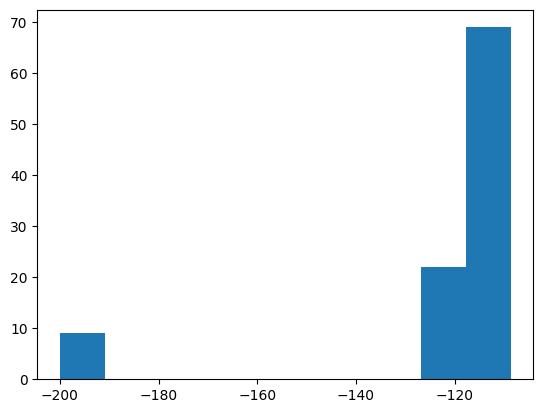

In [97]:
plt.hist(total_rewards)
plt.savefig(f'{data_descr}_reward_total_distr.png')

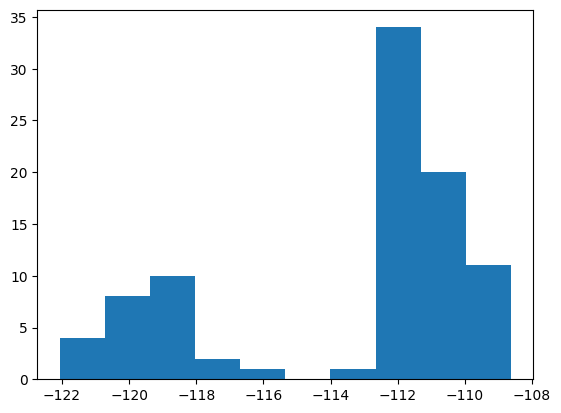

In [98]:
tr = np.array(total_rewards)
plt.hist(tr[tr > -150])
plt.savefig(f'{data_descr}_reward_total_distr_zoom.png')

-111.21000000001999


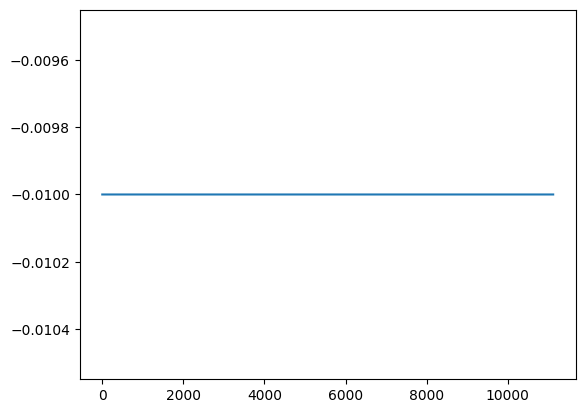

In [99]:

traj_idx = 0
print(total_rewards[traj_idx])
plt.plot(reward_sequences[traj_idx])
plt.savefig(f'{data_descr}_reward_sample_curve.png')